# Quora Insincere Questions Classification
## Detect toxic content to improve online conversations



In [4]:
!wget https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab2_1/quora_data.zip?raw=true -O quora_data.zip

!unzip quora_data.zip

--2021-03-19 15:54:02--  https://github.com/ravi-ilango/acm-dec-2020-nlp/blob/main/lab2_1/quora_data.zip?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab2_1/quora_data.zip?raw=true [following]
--2021-03-19 15:54:02--  https://github.com/ravi-ilango/aicamp-mar-2021/blob/main/lab2_1/quora_data.zip?raw=true
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab2_1/quora_data.zip [following]
--2021-03-19 15:54:02--  https://github.com/ravi-ilango/aicamp-mar-2021/raw/main/lab2_1/quora_data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ravi-ilango/aicamp-mar-2021/main/lab2_1/

In [1]:
import random
import os
from datetime import datetime
import pandas as pd

import torch   
from torchtext import data 
from torch.autograd import Variable

In [2]:
#Reproducing same results
SEED = 2315

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True 

### Load custom dataset

In [5]:
df = pd.read_csv('quora_data/train.csv')

print (f"Number of records: {len(df)}")

df.head()

Number of records: 1306122


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
df['length'] = df['question_text'].apply(lambda s: len(s.split()))
df.sort_values(by=['length'], ascending=False, inplace=True)

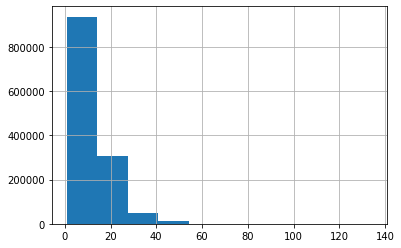

In [7]:
df['length'].hist()

In [8]:
df = df[(df['length'] >= 5) & (df['length'] <= 30)]

In [9]:
df.head()

,qid,question_text,target,length
589578,737e3b7a579a65aeaf88,Why does the media keep saying that Trump supp...,1,30
1179451,e7204436719cb4948912,What is the right luxury watch for me? I want ...,0,30
1112213,d9f07cc67def50c215a8,What form will the digital divide likely take ...,0,30
1179966,e739e624694a7a5a85b8,The person who makes me doesn't use me. The pe...,0,30
1059072,cf83f36e915655cac602,Why are programmers so arrogant and mock every...,1,30


In [10]:
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab

tokenizer = get_tokenizer('basic_english')


In [11]:
# This step takes few minutes

counter = Counter()
for _, row in df.iterrows():
    counter.update(tokenizer(row['question_text']))

vocab = Vocab(counter, min_freq=1)

In [12]:
print(f"Size of TEXT vocabulary: {len(vocab)}\n")

print(f"Commonly used words: {vocab.freqs.most_common(10)}\n")

Size of TEXT vocabulary: 243897

Commonly used words: [('?', 1295821), ('the', 609846), ('what', 444066), ('is', 402302), ('a', 367958), ('to', 360368), ('in', 349517), ('of', 304397), ('i', 282004), ('how', 276081)]



In [13]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

label_pipeline = lambda x: int(x)

### Custom DataLoader

In [14]:
#Split into training and validation datasets

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.5)
train, valid = train_test_split(train, test_size=0.4)

train.sort_values(by=['length'], ascending=False, inplace=True)
test.sort_values(by=['length'], ascending=False, inplace=True)
valid.sort_values(by=['length'], ascending=False, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [15]:
test

,qid,question_text,target,length
1029238,c9b0c3af12b78bb583dd,"Would it be OK for me, a practicing Catholic, ...",0,30
906060,b18a6cc1031f477a78ae,I sometimes wonder why it seems to be acceptab...,1,30
1265616,f808f43fecdf1d10a045,During my Accenture candidate phase (campus re...,0,30
614212,78475721cc7c048db029,How do republicans justify 1.5 trillion in deb...,1,30
1241177,f33b938f62130ae192f4,"What can I, as an Indian who isn't rich enough...",0,30
...,...,...,...,...
78851,0f7015d6c5316028b7a1,What is content delivery network?,0,5
388083,4c0735d4582646dd2e3e,How do process explorers work?,0,5
952388,ba9eb7a06777b5b1a155,What BSDs support Linux applications?,0,5
927002,b5a8d76b24d25e6d24c0,To have sex with aunt?,1,5


In [16]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from torch.utils.data import Dataset

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]

def generate_batch(batch):
    label_list, text_list, text_length_list = [], [], []
    SEQSIZE = len(batch[0]['question_text'].split())
    for row in batch:
        _text = row['question_text']
        _label = row['target']
        label_list.append(label_pipeline(_label))
        processed_text = text_pipeline(_text)[:SEQSIZE]
        text_length_list.append(len(processed_text))
        processed_text += [1]*(SEQSIZE-len(processed_text))
        text_list.append(processed_text)
    label_list = torch.tensor(label_list, dtype=torch.float32)
    text_list = torch.tensor(text_list, dtype=torch.int64)
    text_length_list = torch.tensor(text_length_list, dtype=torch.int64)
    return label_list.to(device), text_list.to(device), text_length_list
    
batch_size = 64

dataloader_train = DataLoader(PandasDataset(train), batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

dataloader_test = DataLoader(PandasDataset(test), batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

dataloader_valid = DataLoader(PandasDataset(valid), batch_size=batch_size, shuffle=False, collate_fn=generate_batch)

In [17]:
len(dataloader_train)

5796

### LSTM Classifier

In [18]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                                                            text_lengths,
                                                            batch_first=True,
                                                            enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]

        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs


#### Instantiate a LSTM Classifier model

In [19]:
#define hyperparameters
size_of_vocab = len(vocab)
embedding_dim = 100
hidden_dim = 32
output_dim = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, hidden_dim, output_dim, num_layers, 
                   bidirectional = True, dropout = dropout)



In [20]:
#architecture
print(model)

#No. of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

# #Initialize the pretrained embedding  ()
# pretrained_embeddings = TEXT.vocab.vectors
# # model.embedding.weight.data.copy_(pretrained_embeddings) # TODO PLEASE USE THIS FOR LSTM

# print(pretrained_embeddings.shape)

classifier(
  (embedding): Embedding(243897, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)
The model has 24,449,157 trainable parameters


In [21]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [22]:
device

device(type='cuda')

### Model Train function 

In [23]:
def train(model, dataloader, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for idx, (label, text, text_lengths) in enumerate(dataloader):
        
        #resets the gradients after every batch
        optimizer.zero_grad()   

        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()
    
        #compute the loss
        loss = criterion(predictions, label)
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
        if idx % 1000 == 0:
            print (f"Completed {idx}/{len(dataloader)}")
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### Model Evaluate function

In [24]:
def evaluate(model, dataloader, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for _, (label, text, text_lengths) in enumerate(dataloader):
        
            #predict
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, label)
            acc = binary_accuracy(predictions, label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(dataloader), epoch_acc / len(dataloader)

### Check model's forward pass

In [25]:
#Check model device type
next(model.parameters()).is_cuda, device

(True, device(type='cuda'))

In [26]:
len(dataloader_train)

5796

In [27]:
for idx, (label, text, text_lengths) in enumerate(dataloader_train):
    print ("text.shape: ", text.shape)
    predictions = model(text, text_lengths)
    print ("predictions.shape: ", predictions.shape)
    break

text.shape:  torch.Size([64, 30])
predictions.shape:  torch.Size([64, 1])


In [28]:
text[0], predictions[0][:10], label[:10]

(tensor([    4,     5,     3,    68,   322,    86,    44,     8,   278,   800,
            97,    27,    64,   527,    28,   530,     2,    12,    61,    12,
            21,    56,   990,    15, 25903,  5533,    97,    26,   257,    15],
        device='cuda:0'),
 tensor([0.4450], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], device='cuda:0'))

### Train the model

This step takes around ~4 min

In [29]:
model_path = 'saved_weights.pt'

N_EPOCHS = 3
best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
     
    ts_string = datetime.now().strftime("%m/%d/%Y %H:%M:%S")
    print(f'\n {ts_string} Epoch: {epoch}')
    #train the model
    train_loss, train_acc = train(model, dataloader_train, optimizer, criterion)
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, dataloader_valid, criterion)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), model_path)

    print(f'\t Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')


 03/19/2021 15:57:07 Epoch: 0
Completed 0/5796
Completed 1000/5796
Completed 2000/5796
Completed 3000/5796
Completed 4000/5796
Completed 5000/5796
	 Train Loss: 0.133 | Train Acc: 95.05%
	 Val. Loss: 0.176 |  Val. Acc: 94.73%

 03/19/2021 16:02:04 Epoch: 1
Completed 0/5796
Completed 1000/5796
Completed 2000/5796
Completed 3000/5796
Completed 4000/5796
Completed 5000/5796
	 Train Loss: 0.105 | Train Acc: 95.89%
	 Val. Loss: 0.187 |  Val. Acc: 94.85%

 03/19/2021 16:06:59 Epoch: 2
Completed 0/5796
Completed 1000/5796
Completed 2000/5796
Completed 3000/5796
Completed 4000/5796
Completed 5000/5796
	 Train Loss: 0.089 | Train Acc: 96.46%
	 Val. Loss: 0.206 |  Val. Acc: 94.89%


### Predict

In [30]:
#load weights
#model.load_state_dict(torch.load(model_path));
model.eval();

def prepare_text(sentence):
    text = text_pipeline(sentence)
    text_length = len(text)
    tensor = torch.tensor(text, dtype=torch.int64)
    length = torch.tensor(text_length, dtype=torch.int64)
    tensor = tensor.unsqueeze(0)
    length = length.unsqueeze(0)
    return tensor.to(device), length

def predict(model, sentence):
    tensor, length = prepare_text(sentence)
    prediction = model(tensor, length)                  #prediction 
    return prediction.item()  

In [31]:
def insincere_or_not(pred):
    return 'Insincere Question' if pred > .5 else 'Normal Question'

In [32]:
#sincere question
pred = predict(model, "What is your favorite person in history?")
print (insincere_or_not(pred))

Normal Question


In [33]:
#insincere question
pred = predict(model, "Why Indian girls go crazy about marrying Shri. Rahul Gandhiji?")
print (insincere_or_not(pred))

Insincere Question


### Note

This notebook used data and code from a blog in https://www.analyticsvidhya.com